In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import os
import shutil

import random as rn


np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

import ray
from ray.tune.integration.keras import TuneReporterCallback
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv


from config import *
from vae_utility import *

Using TensorFlow backend.
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
original_dim = 8

latent_dim = 3
intermediate_dim = 30
kernel_max_norm = 1000.
act_fun = 'relu'
weight_KL_loss = 0.6

Nf_lognorm = 6
Nf_PDgauss = 2

In [3]:
cols_ordered = ['met', 'mt', 'mbb', 'mct2',
        'mlb1', 'lep1Pt', 'nJet30', 'nBJet30_MV2c10', 'weight']

In [44]:
def RecoProb_forVAE(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    w_i = 2

    #Log-Normal distributed variables
    mu = par1[:,:w_i]
    sigma = par2[:,:w_i]
    fraction = par3[:,:w_i]
    x_clipped = K.clip(x[:,:w_i], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:w_i], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(single_NLL, axis=-1)

    #Log-Normal distributed variables
    mu = par1[:,w_i:w_i+1]
    sigma = par2[:,w_i:w_i+1]
    fraction = par3[:,w_i:w_i+1]
    x_clipped = K.clip(x[:,w_i:w_i+1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,w_i:w_i+1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))

    nll_loss += K.sum(single_NLL*w, axis=-1)

    mu = par1[:,w_i+1:Nf_lognorm]
    sigma = par2[:,w_i+1:Nf_lognorm]
    fraction = par3[:,w_i+1:Nf_lognorm]
    x_clipped = K.clip(x[:,w_i+1:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,w_i+1:Nf_lognorm], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))

    nll_loss += K.sum(single_NLL, axis=-1)

    N += Nf_lognorm

    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = K.tf.divide(x[:,N:N+Nf_PDgauss] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,N:N+Nf_PDgauss] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(single_NLL, axis=-1)

    return nll_loss

class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w)

In [45]:
w = 2

In [13]:
x_DNN_input = Input(shape=(original_dim,), name='Input')
hidden_1 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h1')
aux = hidden_1(x_DNN_input)

hidden_2 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h2')

aux = hidden_2(aux)

L_z_mean = Dense(latent_dim, name='Latent_mean')
T_z_mean = L_z_mean(aux)
L_z_sigma_preActivation = Dense(latent_dim, name='Latent_sigma_h')

aux = L_z_sigma_preActivation(aux)
L_z_sigma = Lambda(InverseSquareRootLinearUnit, name='Latent_sigma')
T_z_sigma = L_z_sigma(aux)

L_z_latent = Lambda(sampling, name='Latent_sampling')([T_z_mean, T_z_sigma])
decoder_h1 = Dense(intermediate_dim,
                   activation=act_fun,
                   kernel_constraint=max_norm(kernel_max_norm),
                   name='Decoder_h1')(L_z_latent)

decoder_h2 = Dense(intermediate_dim, activation=act_fun, name='Decoder_h2')(decoder_h1)

L_par1 = Dense(original_dim, name='Output_par1')(decoder_h2)

L_par2_preActivation = Dense(original_dim , name='par2_h')(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit, name='Output_par2')(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm, name='par3_h')(decoder_h2)
L_par3 = Lambda(ClippedTanh, name='Output_par3')(L_par3_preActivation)

fixed_input = Lambda(SmashTo0)(x_DNN_input)
h1_prior = Dense(1,
                 kernel_initializer='zeros',
                 bias_initializer='ones',
                 trainable=False,
                 name='h1_prior'
                )(fixed_input)

L_prior_mean = Dense(latent_dim,
                     kernel_initializer='zeros',
                     bias_initializer='zeros',
                     trainable=True,
                     name='L_prior_mean'
                    )(h1_prior)

L_prior_sigma_preActivation = Dense(latent_dim,
                                    kernel_initializer='zeros',
                                    bias_initializer='ones',
                                    trainable=True,
                                    name='L_prior_sigma_preAct'
                                   )(h1_prior)
L_prior_sigma = Lambda(InverseSquareRootLinearUnit, name='L_prior_sigma')(L_prior_sigma_preActivation)

params = KL.concatenate([T_z_mean, T_z_sigma, L_prior_mean, L_prior_sigma, L_par1, L_par2, L_par3], axis=1)

# params = Params(name='ForMetric')([T_z_mean, T_z_sigma, L_prior_mean, L_prior_sigma, L_par1, L_par2, L_par3])

L_RecoProb = CustomRecoProbLayer(name='RecoNLL')([x_DNN_input, L_par1, L_par2, L_par3])
L_KLLoss = CustomKLLossLayer(name='KL')([T_z_mean, T_z_sigma, L_prior_mean, L_prior_sigma])
vae = Model(inputs=x_DNN_input, outputs=[L_KLLoss, L_RecoProb])

In [14]:
def metric_wapper(layer):

    N = 4*latent_dim

    par1 = layer[:, N: N+original_dim]
    N += original_dim

    par2 = layer[:, N: N+original_dim]
    N += original_dim

    par3 = layer[:, N:N+Nf_lognorm]

    mu = layer[:, :latent_dim]
    sigma = layer[:, latent_dim: 2*latent_dim]
    mu_prior = layer[:, 2*latent_dim: 3*latent_dim]
    sigma_prior = layer[:, 3*latent_dim: 4*latent_dim]

    def metric(y_true, y_pred):

        KL = weight_KL_loss*KL_loss_forVAE(mu,sigma,mu_prior,sigma_prior)
        RecoLoss = RecoProb_forVAE(y_true[:, :original_dim], par1, par2, par3, w=1)

        return (K.mean(RecoLoss+KL))

    return metric

metric = metric_wapper(params)

In [15]:
from keras.models import load_model
custom_objects = {
    'original_dim': 8,
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

w = 2
weight_KL_loss = 0.6

vae = load_model('model_results/single_train/vae_exp/vae_vae_exp.h5', custom_objects=custom_objects)
print ('Loaded')

Loaded


In [21]:
val = np.load(train_val_test + 'background_val.npy')

In [24]:
# all_signal = []
signal_name = []
all_signal_dict = {}

signal_name_path = os.listdir(numpy_sig)

for i, name in enumerate(signal_name_path):
    
    if 'p0' in name:
        signal_name.append(''.join(name.split('Wh_hbb_')[1].split('p0')[0:2]))
    else:
        signal_name.append(''.join(name.split('Wh_hbb_')[1].split('p5')[0:2]))
        
    all_signal_dict[signal_name[-1]] = all_signal[-1]

In [25]:
out_t = vae.predict(val[:,:-1], batch_size=2000)

loss_back_t = np.column_stack((weight_KL_loss*out_t[0]+out_t[1], 
                                  out_t[1], out_t[0])).T

In [26]:
signal_name = ['300_150','300_75','500_0','600_150','750_100','700_350']

In [33]:
sig_list = []
losses_sig = []
for name in signal_name:
    sig = all_signal_dict[name]
    sig_list.append(sig)
    
    aux = vae.predict(sig[:,:-1], batch_size=2000)
    losses_sig.append(np.column_stack((weight_KL_loss*aux[0]+aux[1],
                            aux[1], aux[0])).T)

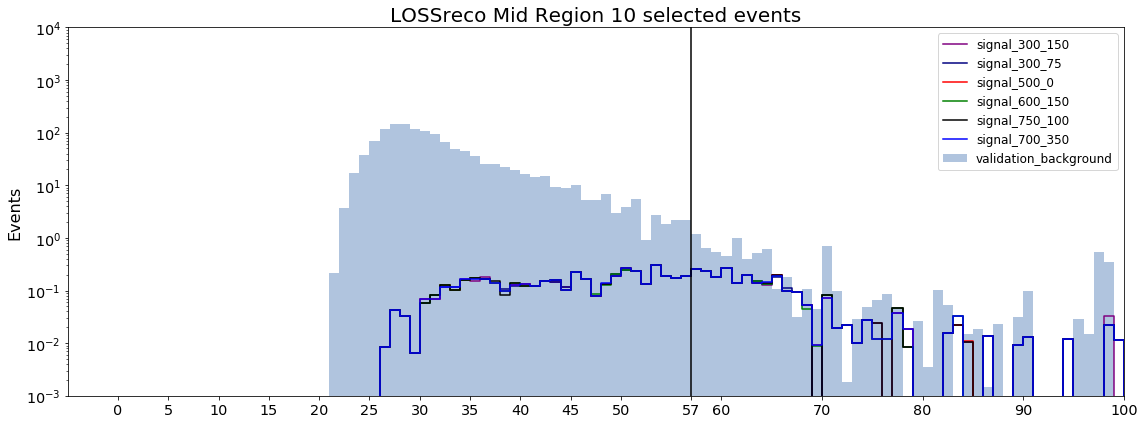

In [43]:
signal_name = ['300_150','300_75','500_0','600_150','750_100','700_350']
signal_name_to_plot = ['300_150','500_0','600_150','700_350']
f,a = plt.subplots(1,1, figsize=(16, 6))

val_factor = 1/(0.4)
color=['purple', 'navy', 'red', 'green', 'black', 'blue']
num_loss = 1
n = 10
density = False

for i,loss in enumerate(losses_sig):

    histo_range = (0, 100)
    bins = (histo_range[1]-histo_range[0])*1
    counts_s, edges_s = np.histogram((loss[num_loss]).astype(float),range=histo_range, bins =bins,
                                    weights=sig_list[i][:,-1],
                                     density=density
                                    )
    a.step(x=edges_s, y=np.append(counts_s, 0),
            where="post", label='signal_{}'.format(signal_name[i]),color=color[i])

histo_range = (0, 100)
bins = (histo_range[1]-histo_range[0])*1

counts_dval, edges_dval = np.histogram((loss_back_t[num_loss]).astype(float),range=histo_range,
                                       bins =bins,
                                            weights=val_factor*val[:,-1],
                                           density=density) 
                                      
th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1]+
            edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)])/2

a.hist((loss_back_t[num_loss]).astype(float),range=histo_range, bins =bins,
            weights=[val_factor]*val[:,-1], 
       stacked=True, 
            density=density,
            color = ['lightsteelblue'], label=['validation_background'])
    

a.set_ylabel('Events', fontsize=16)
a.set_title('LOSSreco Mid Region {} selected events'.format(n), fontsize = 20)

a.set_ylim(10**-3,10**4)
a.tick_params(labelsize='x-large')
a.set_xlim(-5,45)
a.legend(fontsize = 12)
a.set_yscale('log') 
a.axvline(int(th), color='black')
lst = [0,5,10,15,th,20,25,30, 35, 40, 45, 50, 60, 70, 80 ,90 ,100]
lst = [int(x) for x in lst]
a.set_xticks(lst)

plt.tight_layout()